# Import the Necessary Libraries

In [57]:
import re
import nltk
import string
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [2]:
# Download the NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to C:\Users\Not
[nltk_data]     Nabu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Not
[nltk_data]     Nabu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Not
[nltk_data]     Nabu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Not
[nltk_data]     Nabu\AppData\Roaming\nltk_data...


True

# Define and preprocess the summary

In [3]:
# Define a summary here

summary = """
Based on the current financial status, the user has a total spending of $1451.44 and a total earning of $4309.00. The user's spending percentage is 33.68%. An anomaly has been detected on August 12, 2023, with a caution date of August 12, 2023. The metric value is 85.98, indicating a potential issue. The maximum transaction amount is $41.47, and the user's most frequent merchant is a gas station.
In terms of changes in the financial status, the user should be careful with spending. The spending amount has increased by $141.42. However, the earning amount remains the same. The spending percentage has increased by 3.28%. The caution date for the anomaly is August 12, 2023. The maximum transaction amount has decreased by $64.03. Additionally, the user is now spending more on a coffee shop, which was previously a gas station.
Overall, the user's financial status shows an anomaly with increased spending and spending percentage. It is recommended for the user to be cautious with their spending and monitor their financial transactions closely.
"""

In [4]:
# Do some initial processing

text = summary.replace("\n", " ")
sentences = text.split(". ")
sentences = [s.strip() for s in sentences]
sentences[:10]

['Based on the current financial status, the user has a total spending of $1451.44 and a total earning of $4309.00',
 "The user's spending percentage is 33.68%",
 'An anomaly has been detected on August 12, 2023, with a caution date of August 12, 2023',
 'The metric value is 85.98, indicating a potential issue',
 "The maximum transaction amount is $41.47, and the user's most frequent merchant is a gas station",
 'In terms of changes in the financial status, the user should be careful with spending',
 'The spending amount has increased by $141.42',
 'However, the earning amount remains the same',
 'The spending percentage has increased by 3.28%',
 'The caution date for the anomaly is August 12, 2023']

In [5]:
# Tokenization and Lowercasing with better tokenization
def preprocess_text(text):
    # Use NLTK's more advanced word tokenizer
    words = nltk.word_tokenize(text)
    
    # Convert words to lowercase
    words = [word.lower() for word in words]
    
    return words

# Remove punctuation and stop words
def remove_punctuation_and_stopwords(words):
    # Remove punctuation
    words = [word for word in words if word not in string.punctuation]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.add('\'s')

    words = [word for word in words if word not in stop_words]
    
    return words

# Remove digits and numbers with decimal points
def remove_digits(words):
    # Use a regular expression to match digits and numbers with decimal points
    words = [word for word in words if not re.match(r'^\d+(\.\d+)?$', word)]
    
    return words

# Preprocess each document in the dataset and flatten the result into a single list
preprocessed_data = []
for document in sentences:
    words = preprocess_text(document)
    # print(words)
    words = remove_punctuation_and_stopwords(words)
    words = remove_digits(words)
    preprocessed_data.extend(words)  # Use extend to flatten the lists

# Now, preprocessed_data contains a single list of words
preprocessed_data = list(set(preprocessed_data)) # Remove duplicates

# Convert the summary to a list of words and word vectors

In [19]:
from gensim.models import Word2Vec

# Create a list of sentences (each sentence is a list of words)
sentences = [preprocessed_data]

# Train a Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)

# Get the word vectors for your words
word_vectors = model.wv

# Calculate Word Similarity

In [43]:
similarity_matrix = {}

for word1 in preprocessed_data:
    similarity_matrix[word1] = {}
    similar_words = word_vectors.most_similar(word1, topn=5)[1:]
    for word2 in similar_words:
        similarity_matrix[word1][word2[0]] = word2[1]


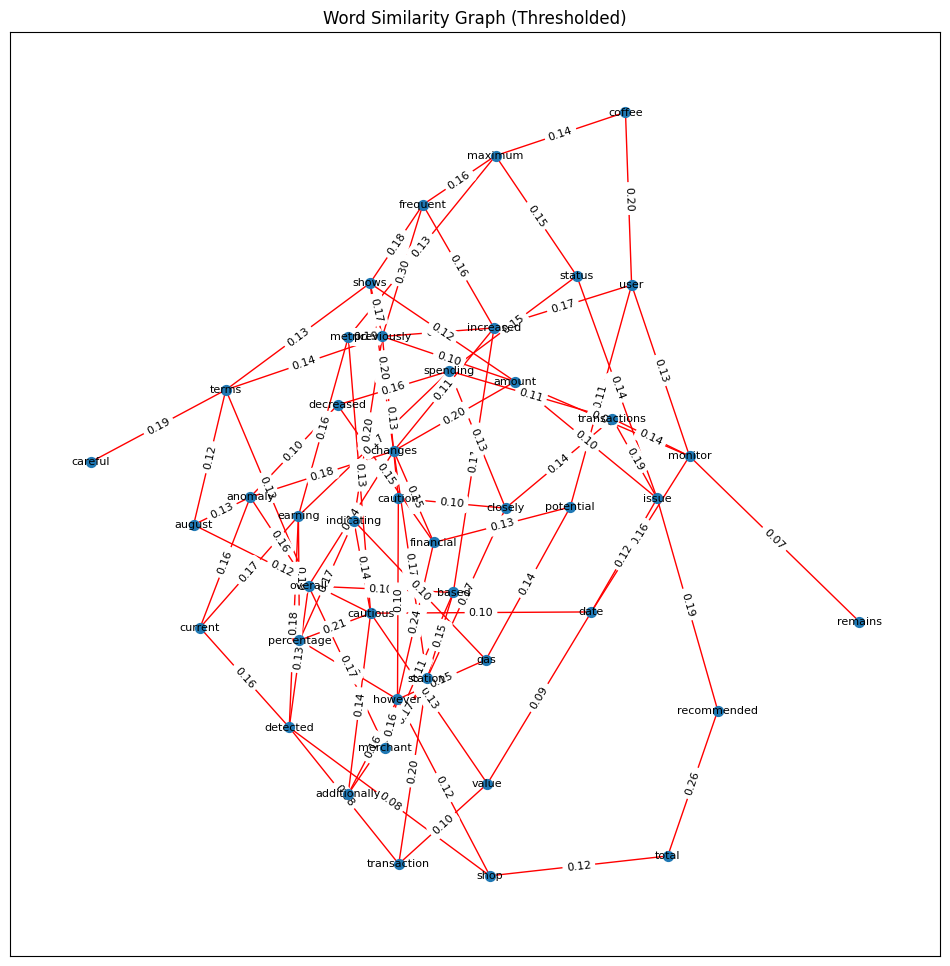

In [58]:
# Create a list of words based on the keys in the similarity dictionary
words = list(similarity_matrix.keys())

# Create a graph
G = nx.Graph()

# Add nodes (words) to the graph
G.add_nodes_from(words)

# Add edges with similarity as weights, filtered by the threshold
for i in range(len(words)):
    for j in range(i + 1, len(words)):
        word1 = words[i]
        word2 = words[j]
        if word1 in similarity_matrix.keys() and word2 in similarity_matrix[word1].keys():
            correlation = similarity_matrix[word1][word2]
            G.add_edge(word1, word2, color="red", weight=correlation)

plt.figure(3,figsize=(12,12)) 

# Position nodes using a spring layout
pos = nx.spring_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=50)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='red')

# Draw labels for nodes
labels = {word: word for word in words}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

# Draw labels for edges (similarity scores)
edge_labels = {(word1, word2): f"{correlation:.2f}" for word1, word2, correlation in G.edges(data="weight")}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)


plt.title("Word Similarity Graph (Thresholded)")
plt.show()

In [55]:
word_ls = []

for word in similarity_matrix.keys():
    # Take each word with it's most similar words
    word1 = word
    word2 = max(similarity_matrix[word], key=similarity_matrix[word].get)
    
    # Get the similarity score
    correlation = similarity_matrix[word][word2]

    # Add the word pair to the list
    word_ls.append((word1, word2, correlation))

In [61]:
# Create dataframe for the summary
word_df = pd.DataFrame(word_ls, columns=["main_word", "related_word", "correlation"])
word_df.head()

,main_word,related_word,correlation
0,percentage,cautious,0.205457
1,based,station,0.148620
2,metric,previously,0.188947
3,additionally,however,0.156781
4,august,percentage,0.145123


In [66]:
word_df.sort_values(by="correlation", ascending=False).head(10)

,main_word,related_word,correlation
15,frequent,previously,0.304306
39,recommended,total,0.259940
26,total,recommended,0.259940
29,coffee,financial,0.247885
9,financial,however,0.238539
43,indicating,caution,0.216465
0,percentage,cautious,0.205457
14,user,coffee,0.203882
17,changes,shows,0.200789
13,transaction,station,0.199072
